<a href="https://colab.research.google.com/github/maloyan/HW_keras/blob/master/hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#DON'T FORGET TO CHANGE Runtime->GPU

In [2]:
!nvidia-smi

Thu Jun  4 00:56:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%%capture
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip;
!unzip ChestXRay2017.zip;

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import tensorflow_addons as tfa

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Строим модель
# Она состоит из трех блоков вида: Свертка->Активация->MaxPooling

# После мы получаем признаки, которые запишем в одномерный массив с помощью Flatten
# Полносвязный слой выход 64->
# Активация Relu->
# 50% Дропаут ->
# Полносвязный слой с одним выходом->
# Нормализация с помощью Sigmoid

def build_model(input_shape):
    input_tensor = Input(shape=input_shape)
    # create the base pre-trained model
    base_model = DenseNet121(
        weights='imagenet',
        input_tensor=input_tensor,
        include_top=False)

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # and a logistic layer -- let's say we have 200 classes
    x = Dense(1, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=input_tensor, outputs=x)
    '''
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    '''
    return model

In [0]:
#Посмотрим на пример из обучающей и тестовой выборки

NORMAL


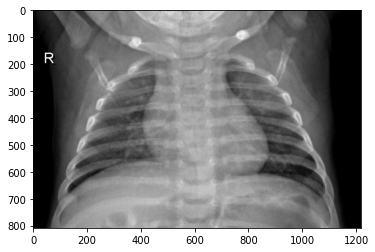

In [7]:
img_normal = load_img('./chest_xray/train/NORMAL/NORMAL2-IM-0588-0001.jpeg')

print('NORMAL')
plt.imshow(img_normal)
plt.show()

PNEUMONIA


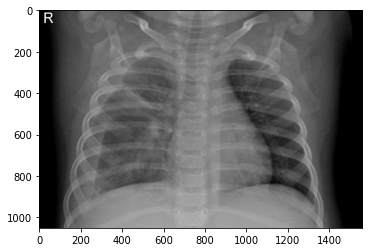

In [26]:
img_pneumonia = load_img('./chest_xray/train/PNEUMONIA/person441_virus_894.jpeg')

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

In [0]:
# Составим Датафрейм с путями и лейблами
# Он нам понадобится для Dataloader 
train = []
train_y = []
test = []
test_y = []

for i in ['PNEUMONIA', 'NORMAL']:
    for j in os.listdir('./chest_xray/train/' + i + '/'):
        train.append(i + '/' + j)
        train_y.append(i)

    for j in os.listdir('./chest_xray/test/' + i + '/'):
        test.append(i + '/' + j)
        test_y.append(i)

df_train = pd.DataFrame({'dir':train, 'label':train_y})
df_test = pd.DataFrame({'dir':test, 'label':test_y})

df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [78]:
df_train.head()

,dir,label
2893,PNEUMONIA/person402_virus_799.jpeg,PNEUMONIA
3481,PNEUMONIA/person995_bacteria_2923.jpeg,PNEUMONIA
4893,NORMAL/NORMAL2-IM-0649-0001.jpeg,NORMAL
198,PNEUMONIA/person1298_virus_2228.jpeg,PNEUMONIA
3525,PNEUMONIA/person142_virus_288.jpeg,PNEUMONIA


In [0]:
IMG_WIDTH, IMG_HEIGHT = 224, 224

TRAIN_DIR = './chest_xray/train/'
TEST_DIR = './chest_xray/test/'

TRAIN_VAL_SPLIT = 0.8
EPOCHS = 3
BATCH = 64

TRAIN_SAMPLES = df_train.shape[0] * TRAIN_VAL_SPLIT
VAL_SAMPLES = df_train.shape[0] * (1 - TRAIN_VAL_SPLIT)

TRAIN_STEPS = TRAIN_SAMPLES // BATCH
VAL_STEPS = VAL_SAMPLES // BATCH

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [0]:
model = build_model(INPUT_SHAPE)
'''
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
'''
model.compile(
    optimizer=optimizers.Adam(),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2),
    metrics=['accuracy', 'mse'])

In [0]:
# this is the augmentation configuration we will use for training
datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip=True)

In [0]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [83]:
train_generator=datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_DIR,
    x_col="dir",
    y_col="label",
    subset="training",
    batch_size=BATCH,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(IMG_WIDTH, IMG_HEIGHT))

Found 4186 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="dir". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [84]:
validation_generator=datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_DIR,
    x_col="dir",
    y_col="label",
    subset="validation",
    batch_size=BATCH,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(IMG_WIDTH, IMG_HEIGHT))

Found 1046 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="dir". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [85]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH,
    class_mode='binary')

Found 624 images belonging to 2 classes.


In [87]:
#model.fit_generator(
model.fit(
    train_generator,
    steps_per_epoch=TRAIN_STEPS,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VAL_STEPS)

65/65 [==============================] - 98s 2s/step - loss: 0.1732 - accuracy: 0.1587 - mse: 0.8246 - val_loss: 0.2645 - val_accuracy: 0.2852 - val_mse: 0.7151


In [0]:
preds = model.predict(test_generator)

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
df_train['label_bin'] = df_train['label'].apply(lambda x: 1 if x=='PNEUMONIA' else 0)
df_test['label_bin'] = df_test['label'].apply(lambda x: 1 if x=='PNEUMONIA' else 0)

In [92]:
mean_squared_error(df_test['label_bin'], preds)

0.39625525418843155

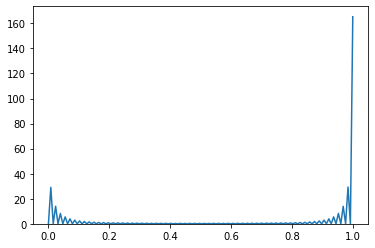

In [94]:
import seaborn as sns
 
sns.kdeplot([i[0] for i in preds])
